<a href="https://colab.research.google.com/github/sean-halpin/cycle_gan_aif1_mouth_only/blob/main/cyclegan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Understanding and Exploration

Dataset of Smiling & non smiling faces from the [MPLab GENKI Database](https://inc.ucsd.edu/mplab/398.php)

### Download

In [ ]:
import urllib.request
url = "https://inc.ucsd.edu/mplab/databases/GENKI-R2009a.zip"
file_name = "GENKI.zip"
urllib.request.urlretrieve(url, file_name)

### Unzip

In [ ]:
import io, zipfile
archive = zipfile.ZipFile('GENKI.zip', 'r')
archive.extractall("dataset/")

### Read Image Labels

In [ ]:
import pandas as pd 
# From the file dataset/GENKI-R2009a/Subsets/GENKI-4K/README.md , we can see the meaning of the labels
# We are interested in if the person is smiling or not
data = pd.read_csv(
    "dataset/GENKI-R2009a/Subsets/GENKI-4K/GENKI-4K_Labels.txt", 
    sep=" ", 
    header=None, 
    names=["smile", "pitch","yaw","roll"],
    index_col=None
)
data.head()

### Create path to image files

In [ ]:
image_symlink_location = "dataset/GENKI-R2009a/Subsets/GENKI-4K/files/"

df1 = data
df1['index_col'] = df1.index
df1['image'] = df1.apply(lambda x: image_symlink_location + "file" + str(int(x['index_col'] + 1)).zfill(4) + ".jpg", axis=1)
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)
df1.head()

### Preview Images

In [ ]:
from matplotlib import pyplot as plt
import cv2

smiles = df1.loc[df1['smile'] == 1]

for i,row in smiles.head(2).iterrows():
  img = cv2.imread(row.image)
  plt.imshow(img)
  plt.title("Smile " + str(i))
  plt.show() 

neutral = df1.loc[df1['smile'] == 0]

for i,row in neutral.head(2).iterrows():
  img = cv2.imread(row.image)
  plt.imshow(img)
  plt.title("Neutral " + str(i))
  plt.show() 

# Data Preparation

### Crop Mouth Only from Images

We will crop out the mouth from the images since this will reduce the amount of data fed to the model which is not important to solving our problem.



In [ ]:
# Adapted code from https://www.geeksforgeeks.org/cropping-faces-from-images-using-opencv-python/
# Here we use Haarcascades to find the coords of the face within the image, we then display the crop and the full image. 
# This looks like exactly what we want

import cv2
  
for i,row in df1.head(1).iterrows():
  # Read the input image
  img = cv2.imread(row.image)
  # Convert into grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # Load the face detect haar cascade
  face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  # Detect faces
  faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    
  # Draw rectangle around the faces and crop the faces
  for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
    faces = img[y:y + h, x:x + w]
    plt.imshow(faces)
    plt.title(str(i))
    plt.show() 
    # Display the output
    plt.imshow(img)
    plt.title(str(i))
    plt.show() 

### Save Cropped Mouths

In [ ]:
! mkdir -p images_cropped

In [ ]:
cropped_image_path = "images_cropped/"
df = data
df['index_col'] = df.index
df['image_cropped'] = df.apply(lambda x: cropped_image_path + "file" + str(int(x['index_col'] + 1)).zfill(4) + ".jpg", axis=1)
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)
df.head()

In [ ]:
from PIL import Image
import numpy as np

def resize_row(row):
  print(row.image)
  img = cv2.imread(row.image)
  # Convert into grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # Load the face detect haar cascade
  face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  # Detect faces
  faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    
  # Draw rectangle around the faces and crop the faces
  # for (x, y, w, h) in faces:
  if len(faces) > 0:
    (x, y, w, h) = faces[0]
    if h >= 64 and w >= 64:
      face = img[y + int(h/2):y + h, x:x + w]
      # plt.imshow(face)
      # plt.show() 
      PIL_image = Image.fromarray(np.uint8(face)).convert('RGB')
      PIL_image.save(row.image_cropped)      
      return True
    else:
      return False
  else:
    return False

df['image_crop_valid'] = df.apply(lambda x: resize_row(x), axis=1)


### Cropped Image Resolutions

In [ ]:
for i,row in df.head(2).iterrows():
  img = cv2.imread(row.image_cropped)
  print("Image " + str(i) + " shape : " + str(img.shape))

### Problem 

The images need to be the same resolution to fit the inputs of our model. 
Lets resize them all. 

### Image Resizing

In [ ]:
! mkdir -p images_resized

In [ ]:
resized_image_path = "images_resized/"
image_x = 128
image_y = 64

df1 = df
df1['index_col'] = df1.index
df1['image_resized'] = df1.apply(lambda x: resized_image_path + "file" + str(int(x['index_col'] + 1)).zfill(4) + ".jpg", axis=1)
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)
df1.head()

In [ ]:
from PIL import Image
import os, sys

def resize():
    for i,row in df1.iterrows():
        try:
            if row.image_crop_valid:
              print(row.image_cropped)
              if os.path.isfile(row.image_cropped):
                  im = Image.open(row.image_cropped)
                  f, e = os.path.splitext(row.image_resized)
                  imResize = im.resize((image_x,image_y), Image.ANTIALIAS)
                  imRGB = imResize.convert("RGB")
                  imRGB.save(f + '.jpg', 'JPEG', quality=94)
        except:
            print("Exception while resizing")
            traceback.print_exc()

resize()

### Preview Resized Images

In [ ]:
from matplotlib import pyplot as plt
import cv2

smiles = df1.loc[(df1['smile'] == 1) & (df1['image_crop_valid'] == True)]

for i,row in smiles.head(2).iterrows():
  img = cv2.imread(row.image_resized)
  plt.imshow(img)
  plt.title("Smile " + str(i))
  plt.show() 

neutral = df1.loc[(df1['smile'] == 0) & (df1['image_crop_valid'] == True)]

for i,row in neutral.head(2).iterrows():
  img = cv2.imread(row.image_resized)
  plt.imshow(img)
  plt.title("Neutral " + str(i))
  plt.show() 

We may have lost a little quality but these cropped & resized images still look recognizable

### Serialize Images as Tensorflow Records

The reason we serialize the images as TFRecords is for performance as well as seamless integration with Tensorflow libraries. 

In [ ]:
import numpy as np, pandas as pd, os
import matplotlib.pyplot as plt, cv2
import tensorflow as tf, re, math

In [ ]:
print('There are %i neutral images and %i smiles images'%(len(neutral),len(smiles)))

In [ ]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [ ]:
def serialize_example(feature0, feature1):
  feature = {
      'image': _bytes_feature(feature0),
      'image_name': _bytes_feature(feature1)
  }
  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

In [ ]:
!mkdir -p neutral_tfrec
!mkdir -p smiles_tfrec

In [ ]:
SIZE = len(neutral)
CT = len(neutral)//SIZE + int(len(neutral)%SIZE!=0)
for j in range(CT):
    print(); print('Writing TFRecord %i of %i...'%(j,CT))
    CT2 = min(SIZE,len(neutral)-j*SIZE)
    with tf.io.TFRecordWriter('neutral_tfrec/neutral%.2i-%i.tfrec'%(j,CT2)) as writer:
        for k in range(CT2):
            # print(neutral.image_resized.iloc[SIZE*j+k])
            img = cv2.imread(neutral.image_resized.iloc[SIZE*j+k])
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # Fix incorrect colors
            img = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, 94))[1].tostring()
            name = neutral.image_resized.iloc[SIZE*j+k].split('.')[0]
            example = serialize_example(
                img, str.encode(name))
            writer.write(example)
            if k%10==0: print(k,', ',end='')

In [ ]:
SIZE = len(smiles)
CT = len(smiles)//SIZE + int(len(smiles)%SIZE!=0)
for j in range(CT):
    print(); print('Writing TFRecord %i of %i...'%(j,CT))
    CT2 = min(SIZE,len(smiles)-j*SIZE)
    with tf.io.TFRecordWriter('smiles_tfrec/smiles%.2i-%i.tfrec'%(j,CT2)) as writer:
        for k in range(CT2):
            # print(smiles.image_resized.iloc[SIZE*j+k])
            img = cv2.imread(smiles.image_resized.iloc[SIZE*j+k])
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # Fix incorrect colors
            img = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, 94))[1].tostring()
            name = smiles.image_resized.iloc[SIZE*j+k].split('.')[0]
            example = serialize_example(
                img, str.encode(name))
            writer.write(example)
            if k%10==0: print(k,', ',end='')

# Model Building

### Prepare Dataset for use

In [ ]:
!pip install tensorflow_addons

In [ ]:
# Imports
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
print(tf.__version__)

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True

session = InteractiveSession(config=config)

In [ ]:
from os import listdir
from os.path import isfile, join
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
strategy = tf.distribute.get_strategy()

In [ ]:
IMAGE_SIZE = [image_y, image_x]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [ ]:
SMILE_FILENAMES = tf.io.gfile.glob(str('smiles_tfrec/smiles*.tfrec'))
print('Smile TFRecord Files:', len(SMILE_FILENAMES))

NEUTRAL_FILENAMES = tf.io.gfile.glob(str('neutral_tfrec/neutral*.tfrec'))
print('neutral TFRecord Files:', len(NEUTRAL_FILENAMES))

In [ ]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [ ]:
smile_ds = load_dataset(SMILE_FILENAMES, labeled=True).batch(1)
neutral_ds = load_dataset(NEUTRAL_FILENAMES, labeled=True).batch(1)

In [ ]:
example_smile = next(iter(smile_ds))
example_neutral = next(iter(neutral_ds))

In [ ]:
plt.subplot(121)
plt.title('Smile')
plt.imshow(example_smile[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Neutral')
plt.imshow(example_neutral[0] * 0.5 + 0.5)

### Generator 

In [ ]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.4))

    result.add(layers.ReLU())

    return result

In [ ]:
def Generator():
    inputs = layers.Input(shape=[image_y,image_x,3])

    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        # downsample(512, 4), # (bs, 2, 2, 512)
        # downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        # upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4, True), # (bs, 16, 16, 1024)
        upsample(256, 4, True), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

### Discriminator

The discriminator model is a standard convolutional neural network model that takes an image as input and must output a binary classification as to whether it is real or fake. [machinelearningmastery](https://machinelearningmastery.com/how-to-code-generative-adversarial-network-hacks/)

In [ ]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[image_y,image_x, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 11, 11, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 8, 8, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [ ]:
with strategy.scope():
    smile_generator = Generator() # transforms neutral to smiling 
    neutral_generator = Generator() # transforms smiling to nuetral

    smile_discriminator = Discriminator() # differentiates real smile and generated smile images
    neutral_discriminator = Discriminator() # differentiates real neutral and generated neutral

In [ ]:
to_smile = smile_generator(example_neutral)

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(example_neutral[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Generated")
plt.imshow(to_smile[0] * 0.5 + 0.5)
plt.show()

print(to_smile)
print(to_smile[0] * 0.5 + 0.5)

### CycleGAN

In [ ]:
class CycleGan(keras.Model):
    def __init__(
        self,
        smile_generator,
        neutral_generator,
        smile_discriminator,
        neutral_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = smile_generator
        self.p_gen = neutral_generator
        self.m_disc = smile_discriminator
        self.p_disc = neutral_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_smile, real_neutral = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # neutral to smile back to neutral
            fake_smile = self.m_gen(real_neutral, training=True)
            cycled_neutral = self.p_gen(fake_smile, training=True)

            # smile to neutral back to smile
            fake_neutral = self.p_gen(real_smile, training=True)
            cycled_smile = self.m_gen(fake_neutral, training=True)

            # generating itself
            same_smile = self.m_gen(real_smile, training=True)
            same_neutral = self.p_gen(real_neutral, training=True)

            # discriminator used to check, inputing real images
            disc_real_smile = self.m_disc(real_smile, training=True)
            disc_real_neutral = self.p_disc(real_neutral, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_smile = self.m_disc(fake_smile, training=True)
            disc_fake_neutral = self.p_disc(fake_neutral, training=True)

            # evaluates generator loss
            smile_gen_loss = self.gen_loss_fn(disc_fake_smile)
            neutral_gen_loss = self.gen_loss_fn(disc_fake_neutral)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_smile, cycled_smile, self.lambda_cycle) + self.cycle_loss_fn(real_neutral, cycled_neutral, self.lambda_cycle)

            # evaluates total generator loss
            total_smile_gen_loss = smile_gen_loss + total_cycle_loss + self.identity_loss_fn(real_smile, same_smile, self.lambda_cycle)
            total_neutral_gen_loss = neutral_gen_loss + total_cycle_loss + self.identity_loss_fn(real_neutral, same_neutral, self.lambda_cycle)

            # evaluates discriminator loss
            smile_disc_loss = self.disc_loss_fn(disc_real_smile, disc_fake_smile)
            neutral_disc_loss = self.disc_loss_fn(disc_real_neutral, disc_fake_neutral)

        # Calculate the gradients for generator and discriminator
        smile_generator_gradients = tape.gradient(total_smile_gen_loss,
                                                  self.m_gen.trainable_variables)
        neutral_generator_gradients = tape.gradient(total_neutral_gen_loss,
                                                  self.p_gen.trainable_variables)

        smile_discriminator_gradients = tape.gradient(smile_disc_loss,
                                                      self.m_disc.trainable_variables)
        neutral_discriminator_gradients = tape.gradient(neutral_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(smile_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(neutral_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(smile_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(neutral_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "smile_gen_loss": total_smile_gen_loss,
            "neutral_gen_loss": total_neutral_gen_loss,
            "smile_disc_loss": smile_disc_loss,
            "neutral_disc_loss": neutral_disc_loss
        }

In [ ]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [ ]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [ ]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [ ]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

# Helper Functions

In [ ]:
!mkdir -p models

In [ ]:
def printSmileFaces(epoch=0,num=5):
  _, ax = plt.subplots(num, 2, figsize=(12, 16))
  for i, img in enumerate(neutral_ds.take(num)):
      print(img)
      prediction = smile_generator(img, training=False)[0].numpy()
      prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
      img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

      ax[i, 0].imshow(img)
      ax[i, 1].imshow(prediction)
      ax[i, 0].set_title("Input Photo")
      ax[i, 1].set_title("Generated Smile Photo")
      ax[i, 0].axis("off")
      ax[i, 1].axis("off")
  plt.show()
  smile_generator.save("models/smile"+str(epoch)+".h5")

In [ ]:
def printNeutralFaces(epoch=0, num=5):
  _, ax = plt.subplots(num, 2, figsize=(12, 16))
  for i, img in enumerate(smile_ds.take(num)):
      prediction = neutral_generator(img, training=False)[0].numpy()
      prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
      img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

      ax[i, 0].imshow(img)
      ax[i, 1].imshow(prediction)
      ax[i, 0].set_title("Input Photo")
      ax[i, 1].set_title("Generated Nuetral Photo")
      ax[i, 0].axis("off")
      ax[i, 1].axis("off")
  plt.show()
  neutral_generator.save("models/neutral"+str(epoch)+".h5")

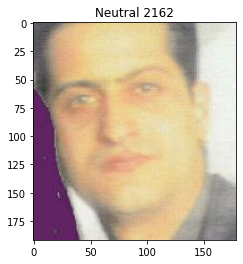

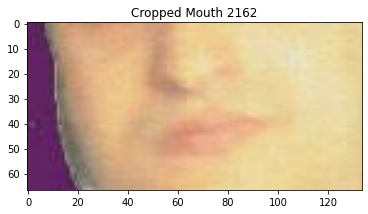

(64, 128, 3)


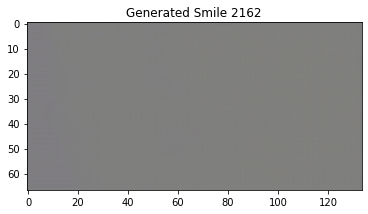

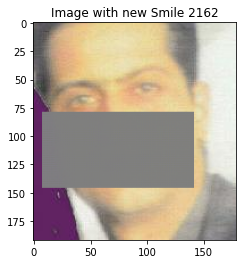

In [120]:
def make_smile():
  for i,row in neutral.head(1).iterrows():
    img = cv2.imread(row.image)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(rgb_img)
    plt.title("Neutral " + str(i))
    plt.show()
    # Load the face detect haar cascade
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
      
    # Draw rectangle around the faces and crop the faces
    for (x, y, w, h) in faces:
    # (x, y, w, h) = faces[0]
      # cv2.rectangle(img, (x, y + int(h/2)), (x+w, y+h), (0, 0, 255), 2)
      mouth = rgb_img[y + int(h/2):y + h, x:x + w]
      plt.imshow(mouth)
      plt.title("Cropped Mouth " + str(i))
      plt.show()
      orig_y,orig_x,d = mouth.shape
      resized_mouth = Image.fromarray(mouth).resize((image_x,image_y), Image.ANTIALIAS)
      # input = tf.reshape(input, [*IMAGE_SIZE, 3])
      input = tf.reshape(tf.keras.preprocessing.image.img_to_array(resized_mouth), [*IMAGE_SIZE, 3])
      input = (tf.cast(input, tf.float32) / 127.5) - 1
      input = tf.expand_dims(input,axis=0)
      prediction = smile_generator(input)[0].numpy()
      prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
      # Resize to original 
      print(prediction.shape)
      resized_prediction = Image.fromarray(prediction).resize((orig_x,orig_y), Image.ANTIALIAS)
      # Display the output
      plt.imshow(resized_prediction)
      plt.title("Generated Smile " + str(i))
      plt.show() 
      # Add generated mouth back to original image
      gen_mouth = np.array(resized_prediction)
      rgb_img[y + int(h/2):y + h, x:x + w] = gen_mouth
      plt.imshow(rgb_img)
      plt.title("Image with new Smile " + str(i))
      plt.show()
      # print(prediction)
      # print(prediction[0] * 0.5 + 0.5)

make_smile()

# Train

In [121]:
with strategy.scope():
    smile_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    neutral_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    smile_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    neutral_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [122]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        smile_generator, neutral_generator, smile_discriminator, neutral_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = smile_generator_optimizer,
        p_gen_optimizer = neutral_generator_optimizer,
        m_disc_optimizer = smile_discriminator_optimizer,
        p_disc_optimizer = neutral_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [123]:
checkpoint_filepath = 'model_checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    verbose=0,
    save_best_only=False,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    options=None,
)

In [124]:
import os.path
from os import path
if path.exists(checkpoint_filepath):
  cycle_gan_model.load_weights(checkpoint_filepath)

In [125]:
class CustomCallback(keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 1 == 0: 
          printNeutralFaces(epoch, 10)
          printSmileFaces(epoch, 10)
          make_smile()

In [ ]:
sample_size = 1000
cycle_gan_model.fit(
    tf.data.Dataset.zip((smile_ds.take(sample_size), neutral_ds.take(sample_size))),
    epochs=10,
    callbacks=[model_checkpoint_callback, CustomCallback()]
)

Epoch 1/10
